<a href="https://www.kaggle.com/code/nikoolaylovyagin/multiple-time-series-prediction-with-pycaret?scriptVersionId=127884066" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Multiple Time Series: Store sales prediction using PyCaret**

# Table of contents
- Importing libraries
- EDA
- Extracting features
- Feature Engineering
- Preprocessing and Baseline Modelling
- Splitting dataset to train and validation sets
- Model Selection using PyCaret
- Submission 
- Suggestions for improvement

# Importing libraries

In [72]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings


# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)  # display all columns
# install pycaret
os.system("pip3 install -q pycaret")

# import the regression module
from pycaret.regression import *

# Import necessary libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.covariance import EllipticEnvelope
from xgboost import XGBRegressor
    # Import SelectKBest and mutual_info_regression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

In [73]:
# Import
train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
#sub = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")   
transactions = pd.read_csv("../input/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])
holidays_events = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")

# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
holidays_events["date"] = pd.to_datetime(holidays_events.date)
oil["date"] = pd.to_datetime(oil.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")



# EDA

In [74]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00


In [75]:
holidays_events.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


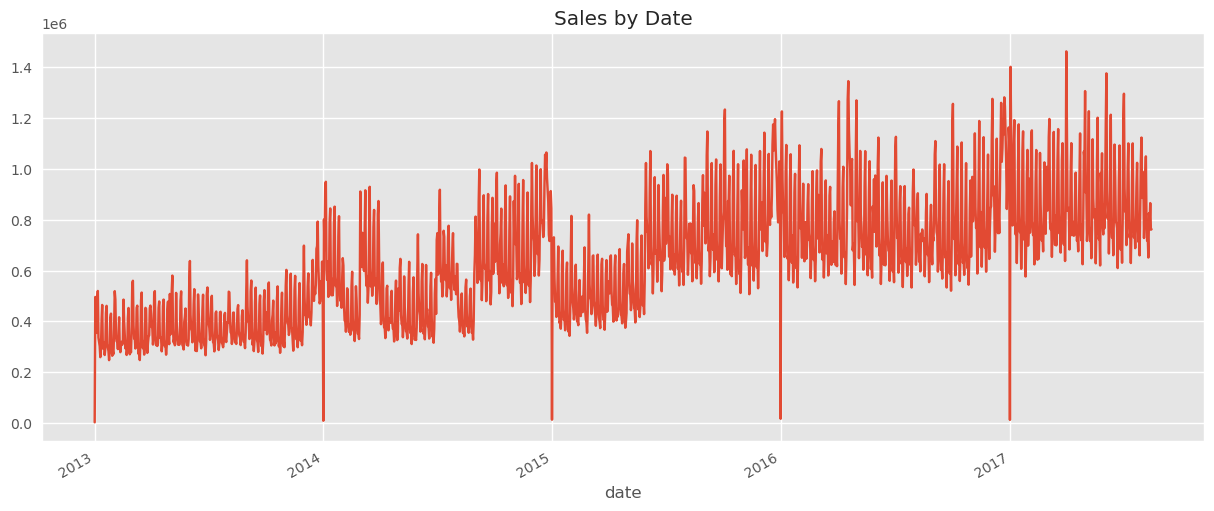

In [76]:
grouped = train.groupby(['date'])['sales'].sum().plot(title = 'Sales by Date', figsize = (15,6))

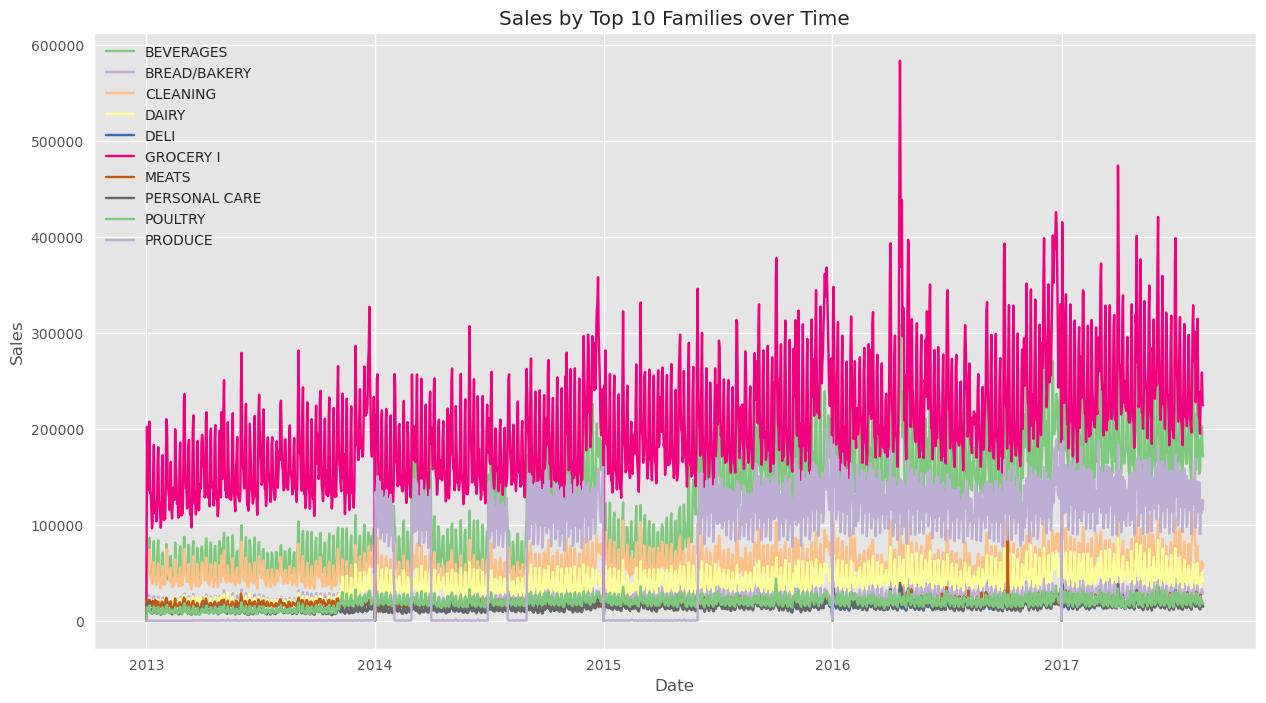

In [77]:
# Calculate the sum of sales for the top 10 families in the training data
family_top10 = train.groupby('family')['sales'].sum()\
    .sort_values(ascending=False)\
    .head(10)

# Define a list of the top 10 families
family_top10_list = ["GROCERY I", "BEVERAGES", "PRODUCE", "CLEANING", "DAIRY", "BREAD/BAKERY", "POULTRY", "MEATS", "PERSONAL CARE", "DELI"]

# Subset the training data to include only the top 10 families
train_subset_top_families = train[train['family'].isin(family_top10_list)]

# Group the sales by date and family for the top 10 families
grouped_families = pd.DataFrame(train_subset_top_families.groupby(['date', 'family'])['sales'].sum())

# Create a line plot of the sales for each family over time
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped_families, x='date', y='sales', hue='family', palette='Accent')
plt.title('Sales by Top 10 Families over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()

From the plot is clear that different products might have different patterns

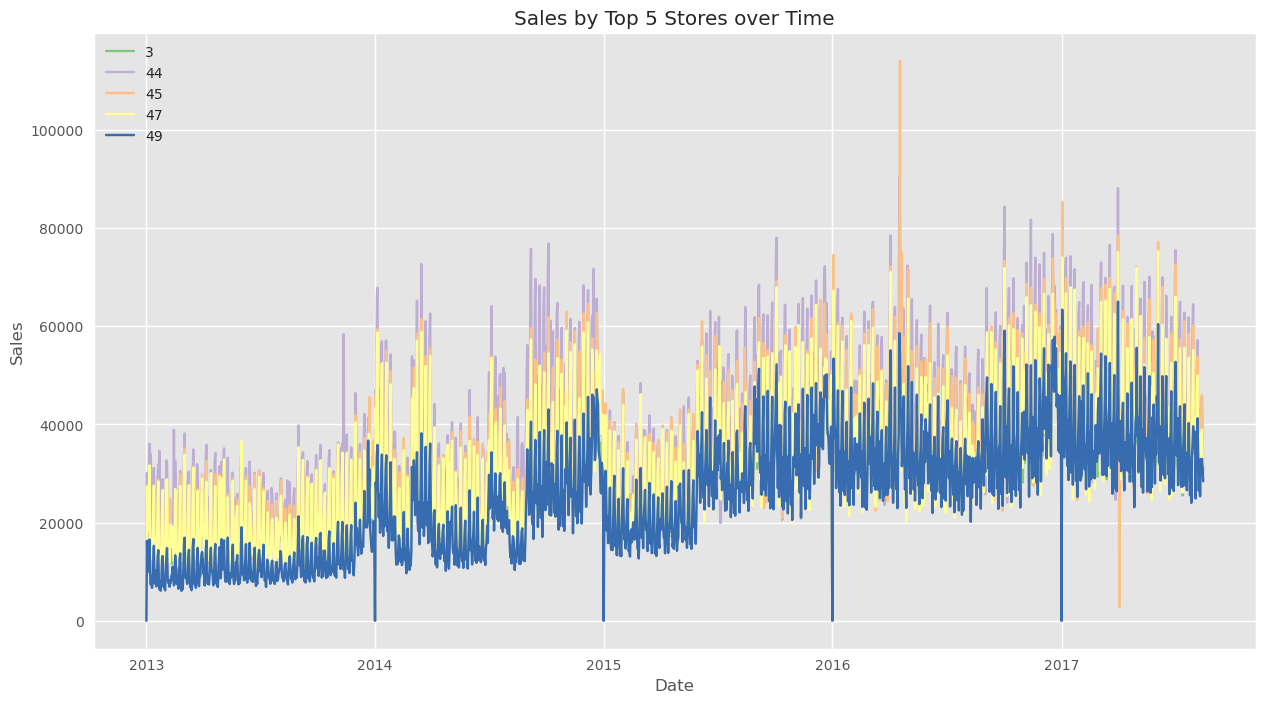

In [78]:
# Calculate the sum of sales for the top 5 stores in the training data
store_nbr_top5 = train.groupby('store_nbr')['sales'].sum()\
    .sort_values(ascending=False)\
    .head(5)

# Define a list of the top 5 stores
store_nbr_top5_list = [44, 45, 47, 3, 49]

# Subset the training data to include only the top 5 stores
train_subset_top_stores = train[train['store_nbr'].isin(store_nbr_top5_list)]

# Group the sales by date and store for the top 5 stores
grouped_stores = pd.DataFrame(train_subset_top_stores.groupby(['date', 'store_nbr'])['sales'].sum())

# Create a line plot of the sales for each store over time
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped_stores, x='date', y='sales', hue='store_nbr', palette='Accent')
plt.title('Sales by Top 5 Stores over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()

Overall patterns are very similar across the stores.

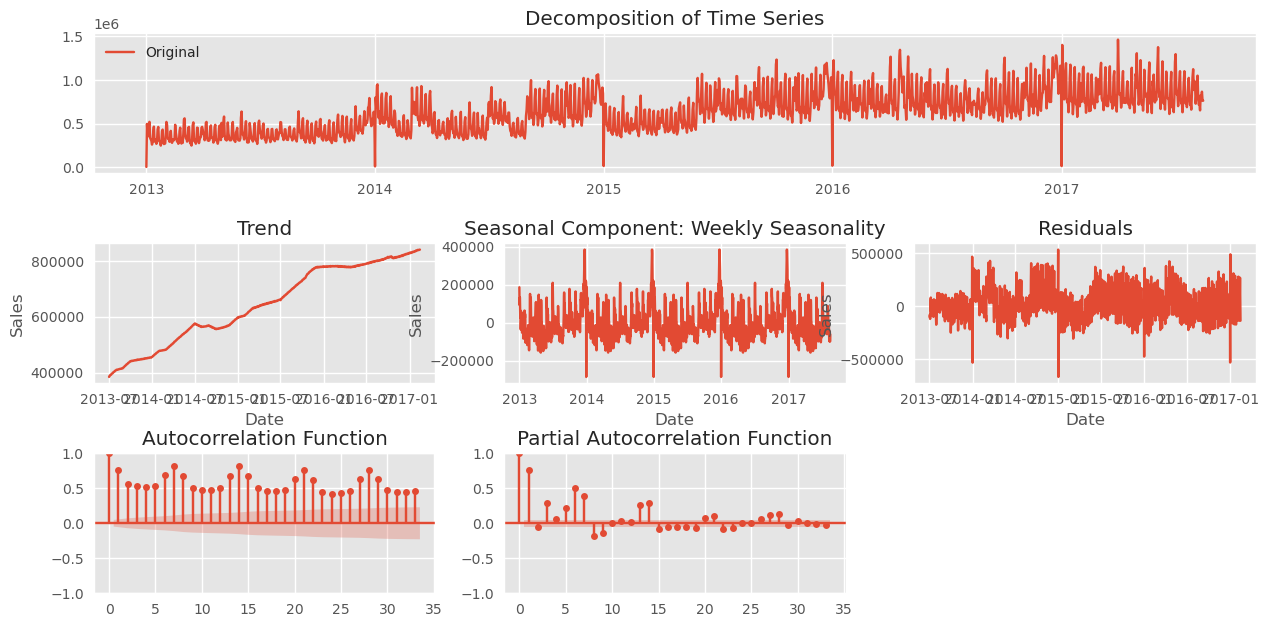

ADF Statistic: -2.616196
p-value: 0.089696


In [79]:
# Aggregate data by date
df = train.groupby(['date']).agg({'sales':'sum'})

# Decompose the time series
decomposition = seasonal_decompose(df, model='additive', period=365)  
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# create a grid of subplots using GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 3, figure=fig)

# plot the original time series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df)
ax1.set_title('Decomposition of Time Series')
ax1.legend(['Original'], loc='best')

# plot the trend component
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(trend)
ax2.set_title('Trend')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')

# plot the seasonal component
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(seasonal)
ax3.set_title('Seasonal Component: Weekly Seasonality')
ax3.set_xlabel('Date')
ax3.set_ylabel('Sales')

# plot the residual component
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(residual)
ax4.set_title('Residuals')
ax4.set_xlabel('Date')
ax4.set_ylabel('Sales')

# plot the autocorrelation function
ax5 = fig.add_subplot(gs[2, 0])
plot_acf(df, ax=ax5)
ax5.set_title('Autocorrelation Function')

# plot the partial autocorrelation function
ax6 = fig.add_subplot(gs[2, 1])
plot_pacf(df, ax=ax6)
ax6.set_title('Partial Autocorrelation Function')

# hide the unused subplot
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

# add spacing between subplots
fig.subplots_adjust(hspace=0.5)

# show the plot
plt.show()

# Check for stationarity using Augmented Dickey-Fuller test
result = adfuller(df['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [80]:
# Convert date column to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# concatenate the datasets
merged = pd.concat([train, test], ignore_index=True)

# print the merged dataset
merged

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00
...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1.00
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0.00
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1.00
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9.00


# Extracting features

In [81]:
oil.head(2)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14


In [82]:
transactions.head(2)

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833


In [83]:
stores.head(2)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


In [84]:
merged = merged.merge(transactions, on = ['date', 'store_nbr'], how='left').copy()
merged = merged.merge(oil, on = 'date', how='left').copy()
merged = merged.merge(stores, on = 'store_nbr', how='left').copy()

In [85]:
merged.rename({'type':'store_type'},axis =1, inplace = True)
merged.tail(2)

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,store_type,cluster
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9.00,NaN,47.26,Quito,Pichincha,B,6
3029399,3029399,2017-08-31,9,SEAFOOD,NaN,0.00,NaN,47.26,Quito,Pichincha,B,6


In [86]:
holidays_events.groupby('locale')['locale_name'].value_counts()

locale    locale_name                   
Local     Quito                              13
          Ambato                             12
          Guaranda                           12
          Latacunga                          12
          Riobamba                           12
          Guayaquil                          11
          Cuenca                              7
          Ibarra                              7
          Cayambe                             6
          El Carmen                           6
          Esmeraldas                          6
          Libertad                            6
          Loja                                6
          Machala                             6
          Manta                               6
          Puyo                                6
          Quevedo                             6
          Salinas                             6
          Santo Domingo                       6
National  Ecuador                           174

In [87]:
holidays_events =holidays_events.drop('description', axis = 1)

In [88]:
national_holidays = holidays_events.loc[holidays_events['locale'] == 'National']
national_holidays.rename({'type': 'national_type', 'transferred': 'national_transferred', 'locale': 'national_locale'},axis =1, inplace = True)
regional_holidays = holidays_events.loc[holidays_events['locale'] == 'Regional']
regional_holidays.rename({'locale_name': 'state', 'type': 'regional_type', 'transferred': 'regional_transferred', 'locale': 'regional_locale'},axis =1, inplace = True)
local_holidays = holidays_events.loc[holidays_events['locale'] == 'Local']
local_holidays.rename({'locale_name': 'city', 'locale': 'local_locale'},axis =1, inplace = True)

In [89]:
regional_holidays.head()

,date,regional_type,regional_locale,state,regional_transferred
1,2012-04-01,Holiday,Regional,Cotopaxi,False
7,2012-06-25,Holiday,Regional,Imbabura,False
23,2012-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,False
24,2012-11-07,Holiday,Regional,Santa Elena,False
47,2013-04-01,Holiday,Regional,Cotopaxi,False


In [90]:
merged.tail()

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,store_type,cluster
3029395,3029395,2017-08-31,9,POULTRY,NaN,1.00,NaN,47.26,Quito,Pichincha,B,6
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0.00,NaN,47.26,Quito,Pichincha,B,6
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1.00,NaN,47.26,Quito,Pichincha,B,6
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9.00,NaN,47.26,Quito,Pichincha,B,6
3029399,3029399,2017-08-31,9,SEAFOOD,NaN,0.00,NaN,47.26,Quito,Pichincha,B,6


In [91]:
merged = merged.merge(regional_holidays, on = ['date', 'state'], how='left').copy()
print(len(merged))

3029400


In [92]:
merged = merged.merge(local_holidays, on = ['date', 'city'], how='left').copy()
print(len(merged))
merged = merged.drop_duplicates(subset=['date', 'city', 'sales', 'store_nbr', 'family'], keep='first')
print(len(merged))

3029664
3029400


In [93]:
merged = merged.merge(national_holidays, on = ['date'], how='left').copy()
print(len(merged))
merged = merged.drop_duplicates(subset=['date', 'city', 'sales', 'store_nbr', 'family'], keep='first')
print(len(merged))

3036528
3029400


In [94]:
merged.tail()

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,store_type,cluster,regional_type,regional_locale,regional_transferred,type,local_locale,transferred,national_type,national_locale,locale_name,national_transferred
3036523,3029395,2017-08-31,9,POULTRY,NaN,1.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3036524,3029396,2017-08-31,9,PREPARED FOODS,NaN,0.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3036525,3029397,2017-08-31,9,PRODUCE,NaN,1.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3036526,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3036527,3029399,2017-08-31,9,SEAFOOD,NaN,0.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
merged = merged.set_index('id')
merged = merged.reset_index(drop=True)

In [96]:
merged.tail(2)

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,store_type,cluster,regional_type,regional_locale,regional_transferred,type,local_locale,transferred,national_type,national_locale,locale_name,national_transferred
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029399,2017-08-31,9,SEAFOOD,NaN,0.00,NaN,47.26,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


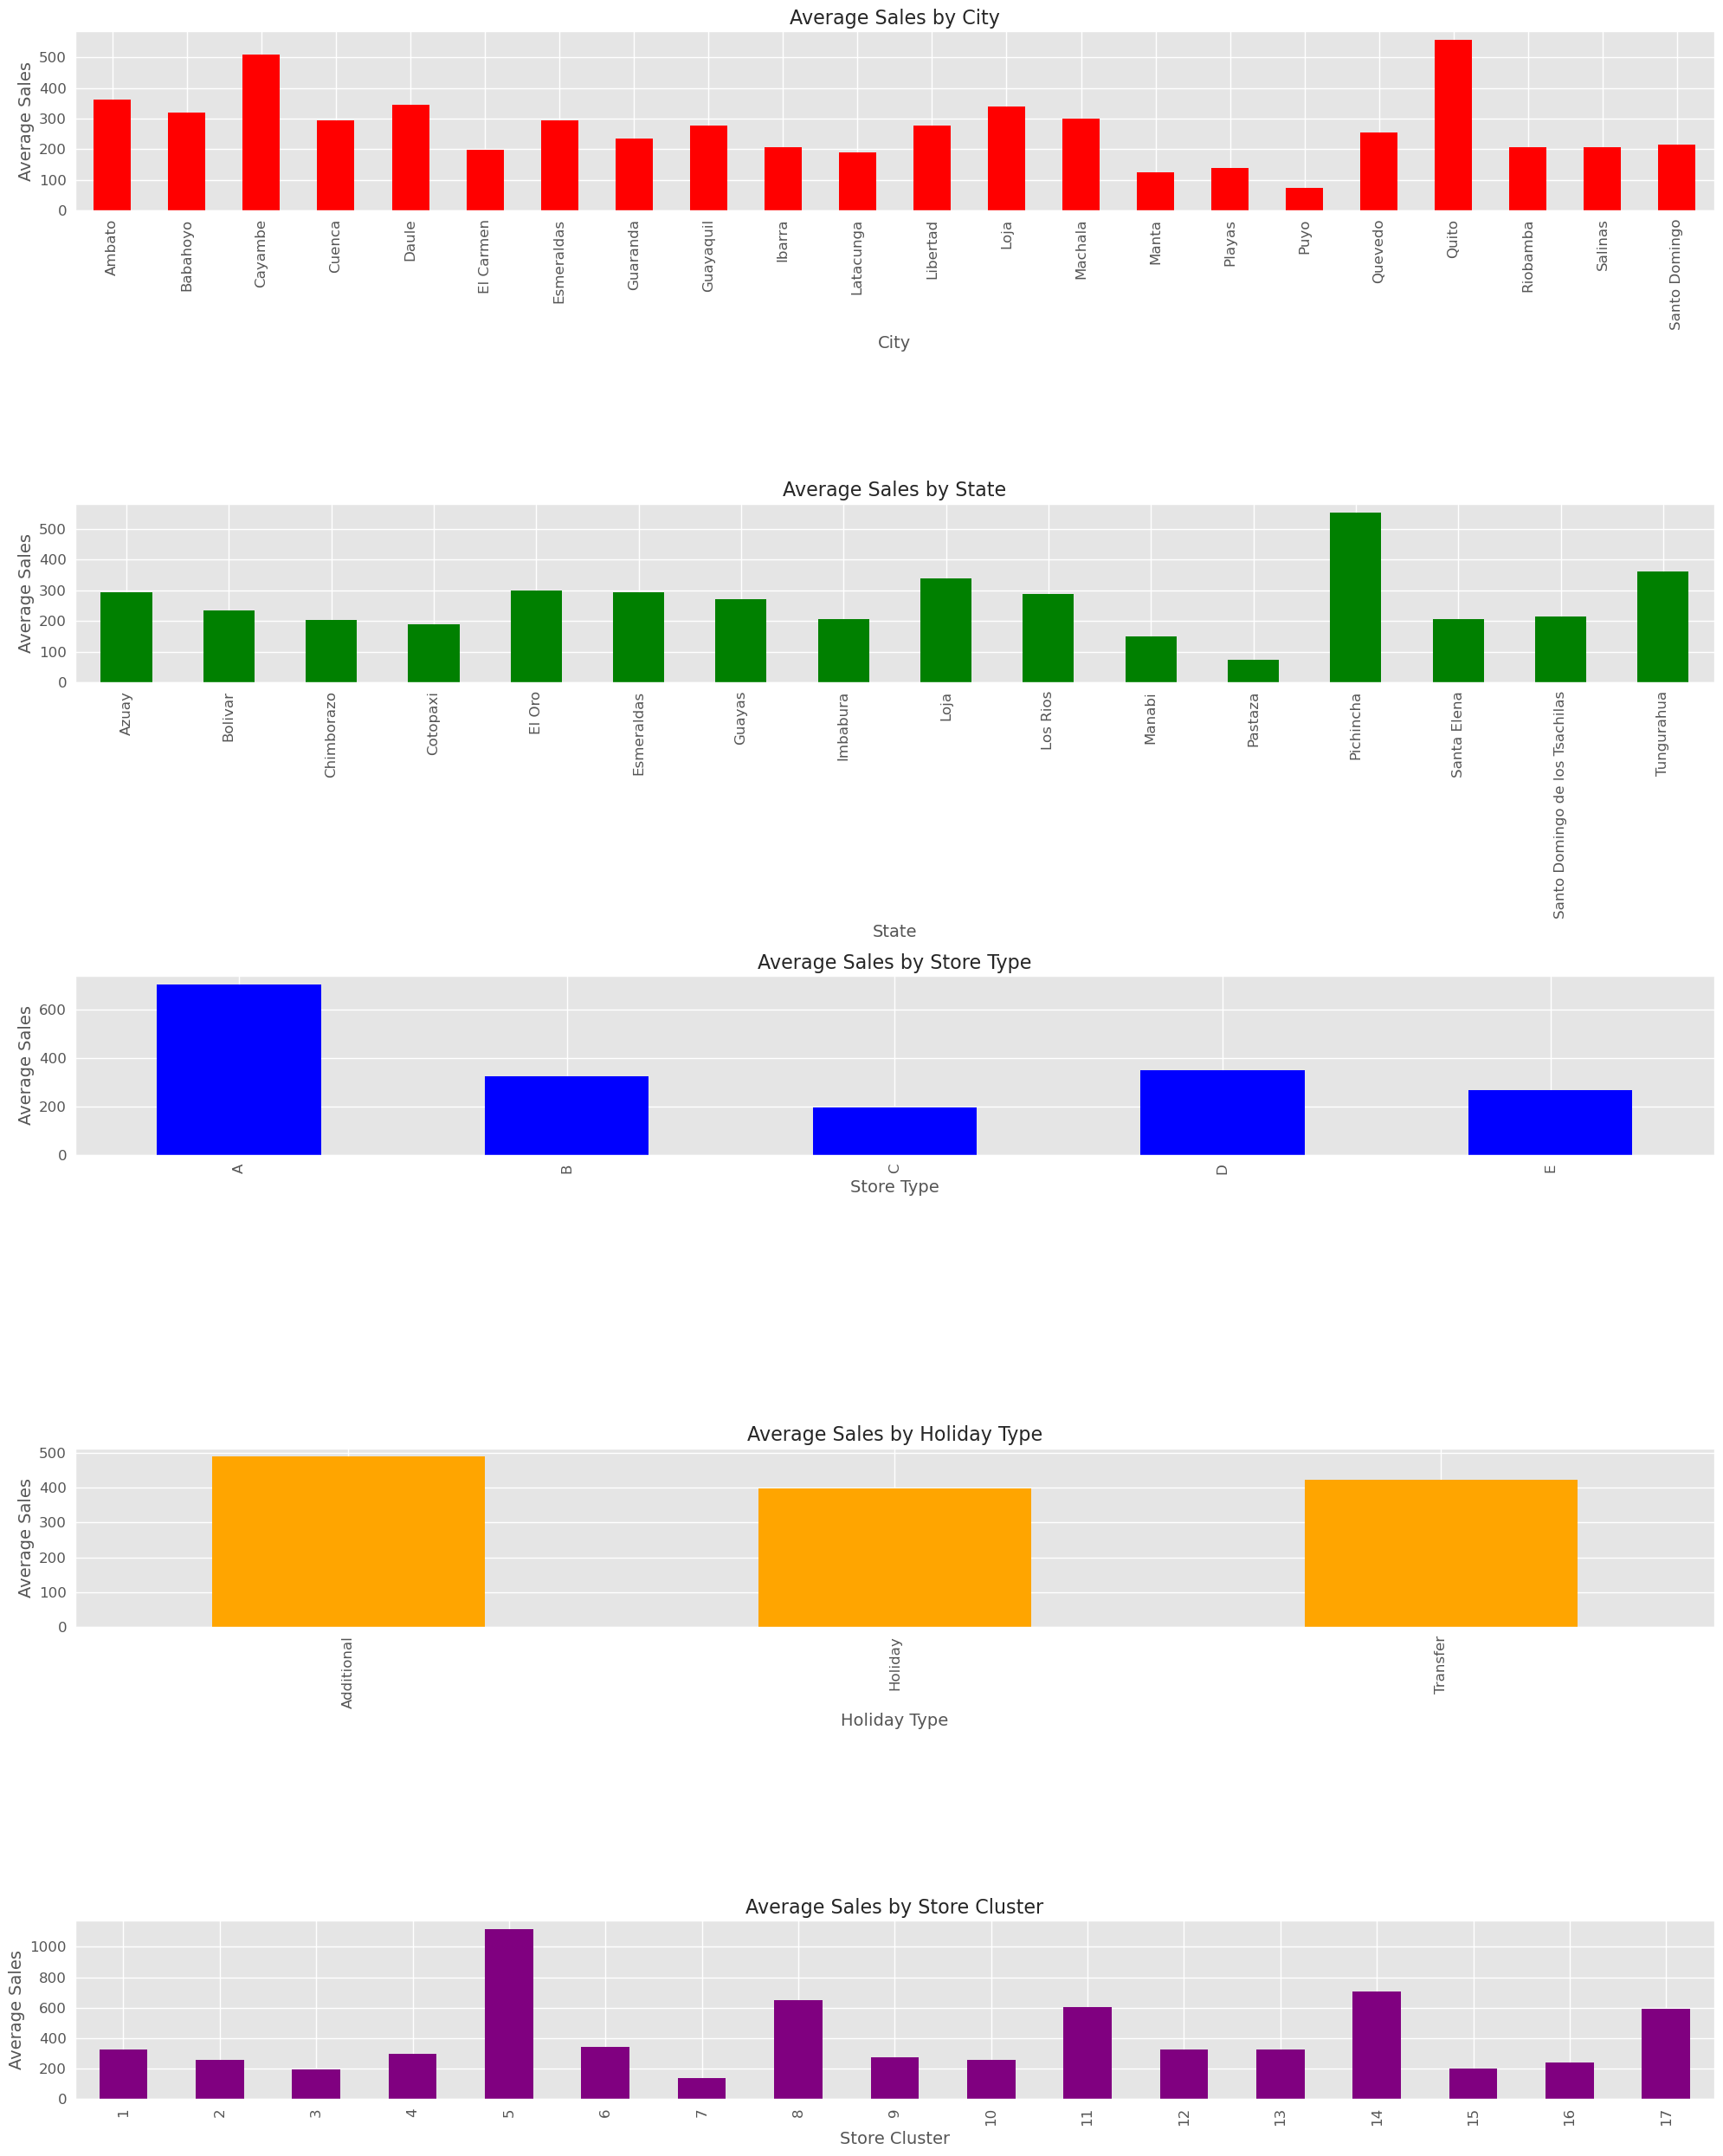

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 25))

plt.subplot(511)
merged.groupby(['city'])['sales'].mean().plot.bar(color='red')
plt.title('Average Sales by City', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(512)
merged.groupby(['state'])['sales'].mean().plot.bar(color='green')
plt.title('Average Sales by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(513)
merged.groupby(['store_type'])['sales'].mean().plot.bar(color='blue')
plt.title('Average Sales by Store Type', fontsize=16)
plt.xlabel('Store Type', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(514)
merged.groupby(['type'])['sales'].mean().plot.bar(color='orange')
plt.title('Average Sales by Holiday Type', fontsize=16)
plt.xlabel('Holiday Type', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(515)
merged.groupby(['cluster'])['sales'].mean().plot.bar(color='purple')
plt.title('Average Sales by Store Cluster', fontsize=16)
plt.xlabel('Store Cluster', fontsize=14)
plt.ylabel('Average Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

# Feature Engineering

In [98]:
merged[['regional_type', 'regional_locale', 'regional_transferred', 'national_locale', 'local_locale', 'locale_name']] = \
    merged[['regional_type', 'regional_locale', 'regional_transferred', 'national_locale', 'local_locale', 'locale_name']].notnull().astype('int')
merged[['regional_type', 'regional_locale', 'regional_transferred', 'national_locale', 'local_locale', 'locale_name']] = merged[['regional_type', 'regional_locale', 'regional_transferred', 'national_locale', 'local_locale', 'locale_name']].fillna(0)
merged[['type', 'transferred', 'national_type', 'national_transferred']] = merged[['type', 'transferred', 'national_type', 'national_transferred']].fillna('not_holiday')

In [99]:
for col in merged.columns:
    unique_vals = merged[col].nunique()
    print(f"{col}: {unique_vals} unique values")

date: 1700 unique values
store_nbr: 54 unique values
family: 33 unique values
sales: 379610 unique values
onpromotion: 367 unique values
transactions: 4993 unique values
dcoilwtico: 998 unique values
city: 22 unique values
state: 16 unique values
store_type: 5 unique values
cluster: 17 unique values
regional_type: 2 unique values
regional_locale: 2 unique values
regional_transferred: 2 unique values
type: 4 unique values
local_locale: 2 unique values
transferred: 3 unique values
national_type: 7 unique values
national_locale: 2 unique values
locale_name: 2 unique values
national_transferred: 3 unique values


In [100]:
merged.national_transferred.value_counts()

not_holiday    2774574
False           242352
True             12474
Name: national_transferred, dtype: int64

In [101]:
# Decompose the time series for each combination of product family and nstore
grouped = train.groupby(['family', 'store_nbr'])

# Add features to the training dataset
merged = merged.copy()
merged['day_of_week'] = merged['date'].dt.dayofweek
merged['day'] = merged['date'].dt.day ## it may be useful since there might be most frequent salary dates
merged['month'] = merged['date'].dt.month
merged['quarter'] = merged['date'].dt.quarter
merged['year'] = merged['date'].dt.year
merged['trend_slope'] = np.arange(len(merged)) / len(merged)
## we should use lag features with with caution because they can represent data leakage if available in validation set. We want use 7 or 14 days lag because we are to predict for 15 days in test set. 
merged['previous_month_sales'] = merged.groupby(['family', 'store_nbr'])['sales'].shift(28) ## it might catch both weekly and monthly patterns
merged['previous_quarter_sales'] = merged.groupby(['family', 'store_nbr'])['sales'].shift(91) ## it might catch both weekly and quaterly patterns
merged['previous_year_sales'] = merged.groupby(['family', 'store_nbr'])['sales'].shift(364) ## it might catch both weekly and yearly patterns


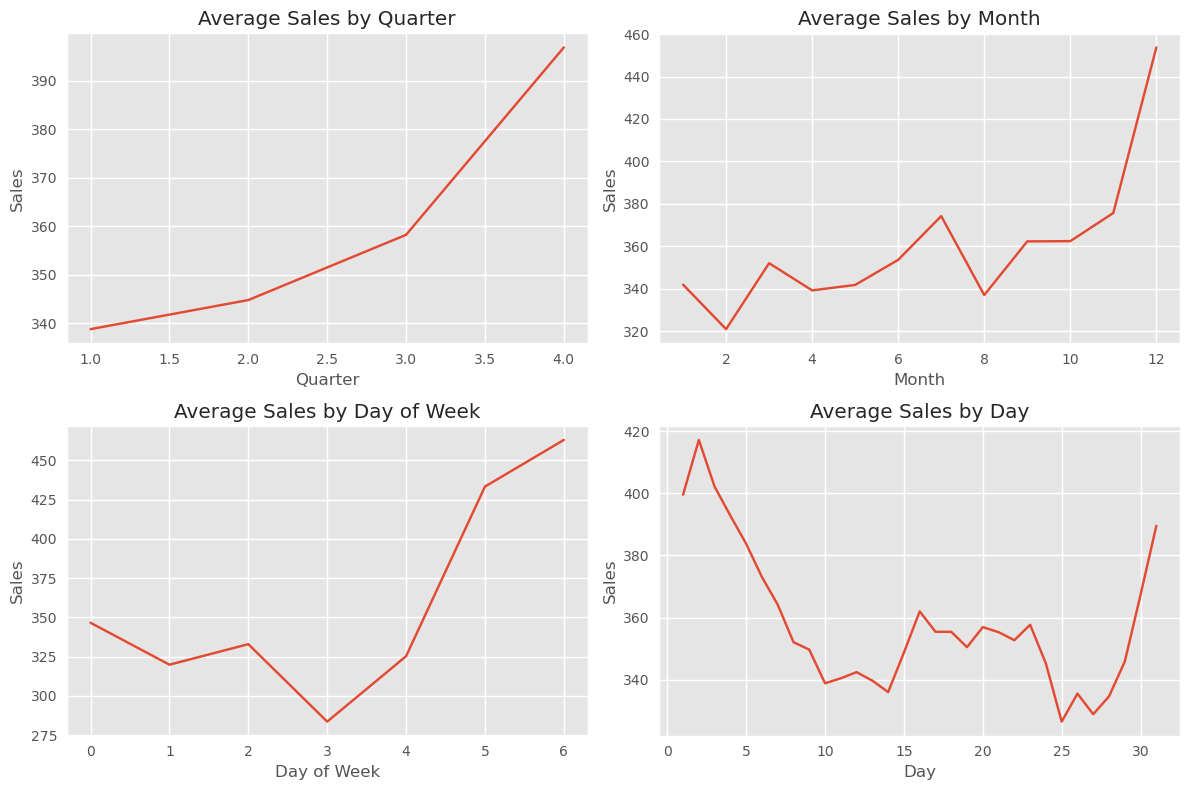

In [102]:
plt.figure(figsize=(12, 8))

plt.subplot(221)
merged.groupby(['quarter'])['sales'].mean().plot(title='Average Sales by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Sales')

plt.subplot(222)
merged.groupby(['month'])['sales'].mean().plot(title='Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')

plt.subplot(223)
merged.groupby(['day_of_week'])['sales'].mean().plot(title='Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')

plt.subplot(224)
merged.groupby(['day'])['sales'].mean().plot(title='Average Sales by Day')
plt.xlabel('Day')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()

In [103]:
# Perform backward imputation for missing values in 'dcoilwtico' feature
merged['dcoilwtico'] = merged['dcoilwtico'].fillna(method='backfill')
print(merged['dcoilwtico'].isna().sum())

0


In [104]:
print('mean sales when transaction data is missing:', merged[merged['transactions'].isna()]['sales'].mean())
print('median sales when transaction data is missing:', merged[merged['transactions'].isna()]['sales'].median())

mean sales when transaction data is missing: 9.691575
median sales when transaction data is missing: 0.0


If the sales are zero, we impute the transactions as 0. If the sales are not zero, we use the fillna function along with the groupby method to impute the null values with the median of transactions for the particular store and item. This ensures that the imputation is done based on sales figures for only those rows where sales are present, and based on the median of transactions for the corresponding store and item.

In [105]:
# Fill missing transactions values with median transactions grouped by store and family
# Only fill missing values for rows where sales is not equal to 0
merged['transactions'] = np.where(merged['sales']==0, 0, merged['transactions'].fillna(merged.groupby(['store_nbr','family'])['transactions'].transform('median')))

# Check count of missing values in 'transactions' column
print("Count of missing 'transactions' values:", merged['transactions'].isna().sum())


Count of missing 'transactions' values: 0


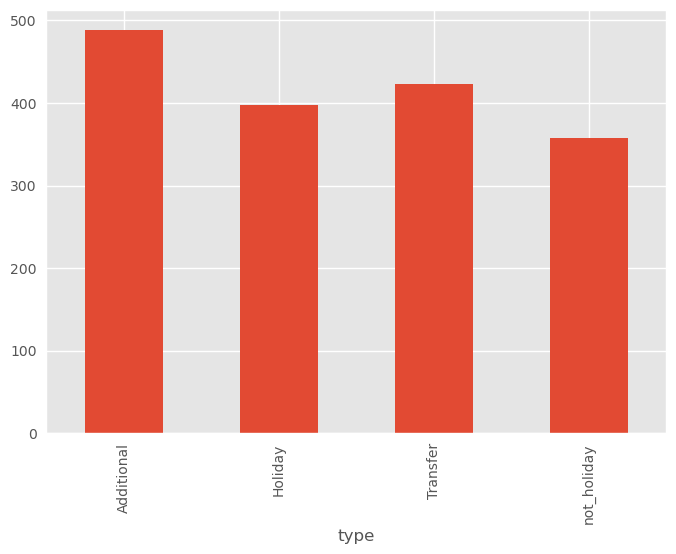

In [106]:
# Calculate mean sales for each event type
sales_by_event_type = merged.groupby(['type'])['sales'].mean().plot.bar()
plt.show()

In [107]:
merged.locale_name.value_counts()

0    2774574
1     254826
Name: locale_name, dtype: int64

In [108]:
merged.describe()

,store_nbr,sales,onpromotion,transactions,dcoilwtico,cluster,regional_type,regional_locale,regional_transferred,local_locale,national_locale,locale_name,day_of_week,day,month,quarter,year,trend_slope,previous_month_sales,previous_quarter_sales,previous_year_sales
count,3029400.00,3000888.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,3029400.00,2979504.00,2867238.00,2380752.00
mean,27.50,357.78,2.64,1202.34,67.67,8.48,0.00,0.00,0.00,0.00,0.08,0.08,3.00,15.70,6.22,2.42,2014.86,0.50,357.07,352.01,327.08
std,15.59,1102.00,12.33,1146.24,25.66,4.65,0.02,0.02,0.02,0.06,0.28,0.28,2.00,8.80,3.37,1.10,1.36,0.29,1101.06,1089.59,1021.78
min,1.00,0.00,0.00,0.00,26.19,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2013.00,0.00,0.00,0.00,0.00
25%,14.00,0.00,0.00,0.00,46.39,4.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8.00,3.00,1.00,2014.00,0.25,0.00,0.00,0.00
50%,27.50,11.00,0.00,1118.00,53.06,8.50,0.00,0.00,0.00,0.00,0.00,0.00,3.00,16.00,6.00,2.00,2015.00,0.50,11.00,10.00,8.00
75%,41.00,195.85,0.00,1753.00,95.73,13.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,23.00,9.00,3.00,2016.00,0.75,195.00,192.00,177.83
max,54.00,124717.00,741.00,8359.00,110.62,17.00,1.00,1.00,1.00,1.00,1.00,1.00,6.00,31.00,12.00,4.00,2017.00,1.00,124717.00,124717.00,124717.00


In [109]:
merged.describe(include='object')

,family,city,state,store_type,type,transferred,national_type,national_transferred
count,3029400,3029400,3029400,3029400,3029400,3029400,3029400,3029400
unique,33,22,16,5,4,3,7,3
top,AUTOMOTIVE,Quito,Pichincha,D,not_holiday,not_holiday,not_holiday,not_holiday
freq,91800,1009800,1065900,1009800,3017091,3017091,2774574,2774574


We can safely drop several features from our dataset to reduce dimenionality:

In [110]:
#merged.drop(['locale_name'], axis = 1, inplace = True)

In [111]:
merged.isna().sum()

date                           0
store_nbr                      0
family                         0
sales                      28512
onpromotion                    0
transactions                   0
dcoilwtico                     0
city                           0
state                          0
store_type                     0
cluster                        0
regional_type                  0
regional_locale                0
regional_transferred           0
type                           0
local_locale                   0
transferred                    0
national_type                  0
national_locale                0
locale_name                    0
national_transferred           0
day_of_week                    0
day                            0
month                          0
quarter                        0
year                           0
trend_slope                    0
previous_month_sales       49896
previous_quarter_sales    162162
previous_year_sales       648648
dtype: int

Spearman Correlation between Sales and Oil price: -0.6081


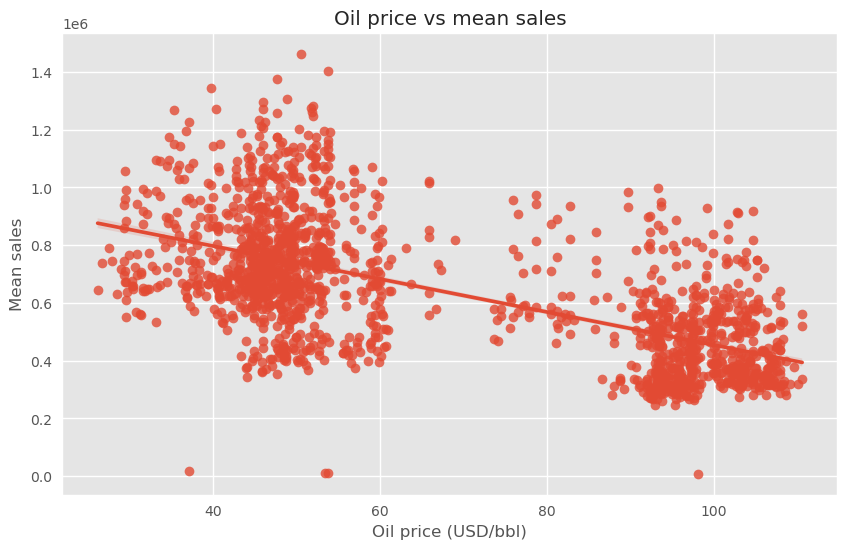

In [112]:
grouped = pd.DataFrame(train.groupby('date')['sales'].sum())
grouped = grouped.merge(oil, on = 'date', how='left').copy()


# Aggregate data by date
grouped = train.groupby(['date']).agg({'sales':'sum'})

# Merge with oil dataset
grouped = grouped.merge(oil, on='date', how='left')

# Fill missing oil prices using the previous value
grouped['dcoilwtico'].fillna(method='ffill', inplace=True)

# Compute the Spearman correlation coefficient between sales and oil price
corr = grouped.corr(method='spearman').sales.loc["dcoilwtico"]
print("Spearman Correlation between Sales and Oil price: {:,.4f}".format(corr))

# Plot the relationship between oil price and mean sales
plt.figure(figsize=(10,6))
sns.regplot(data=grouped, x='dcoilwtico', y='sales')
plt.title("Oil price vs mean sales")
plt.xlabel("Oil price (USD/bbl)")
plt.ylabel("Mean sales")
plt.show()

If daily oil price is high, we expect that the Ecuador's economy is bad and it means the price of product increases and sales decreases. There is a negative relationship here.

Spearman Correlation between Sales and Onpromotion: 0.5380


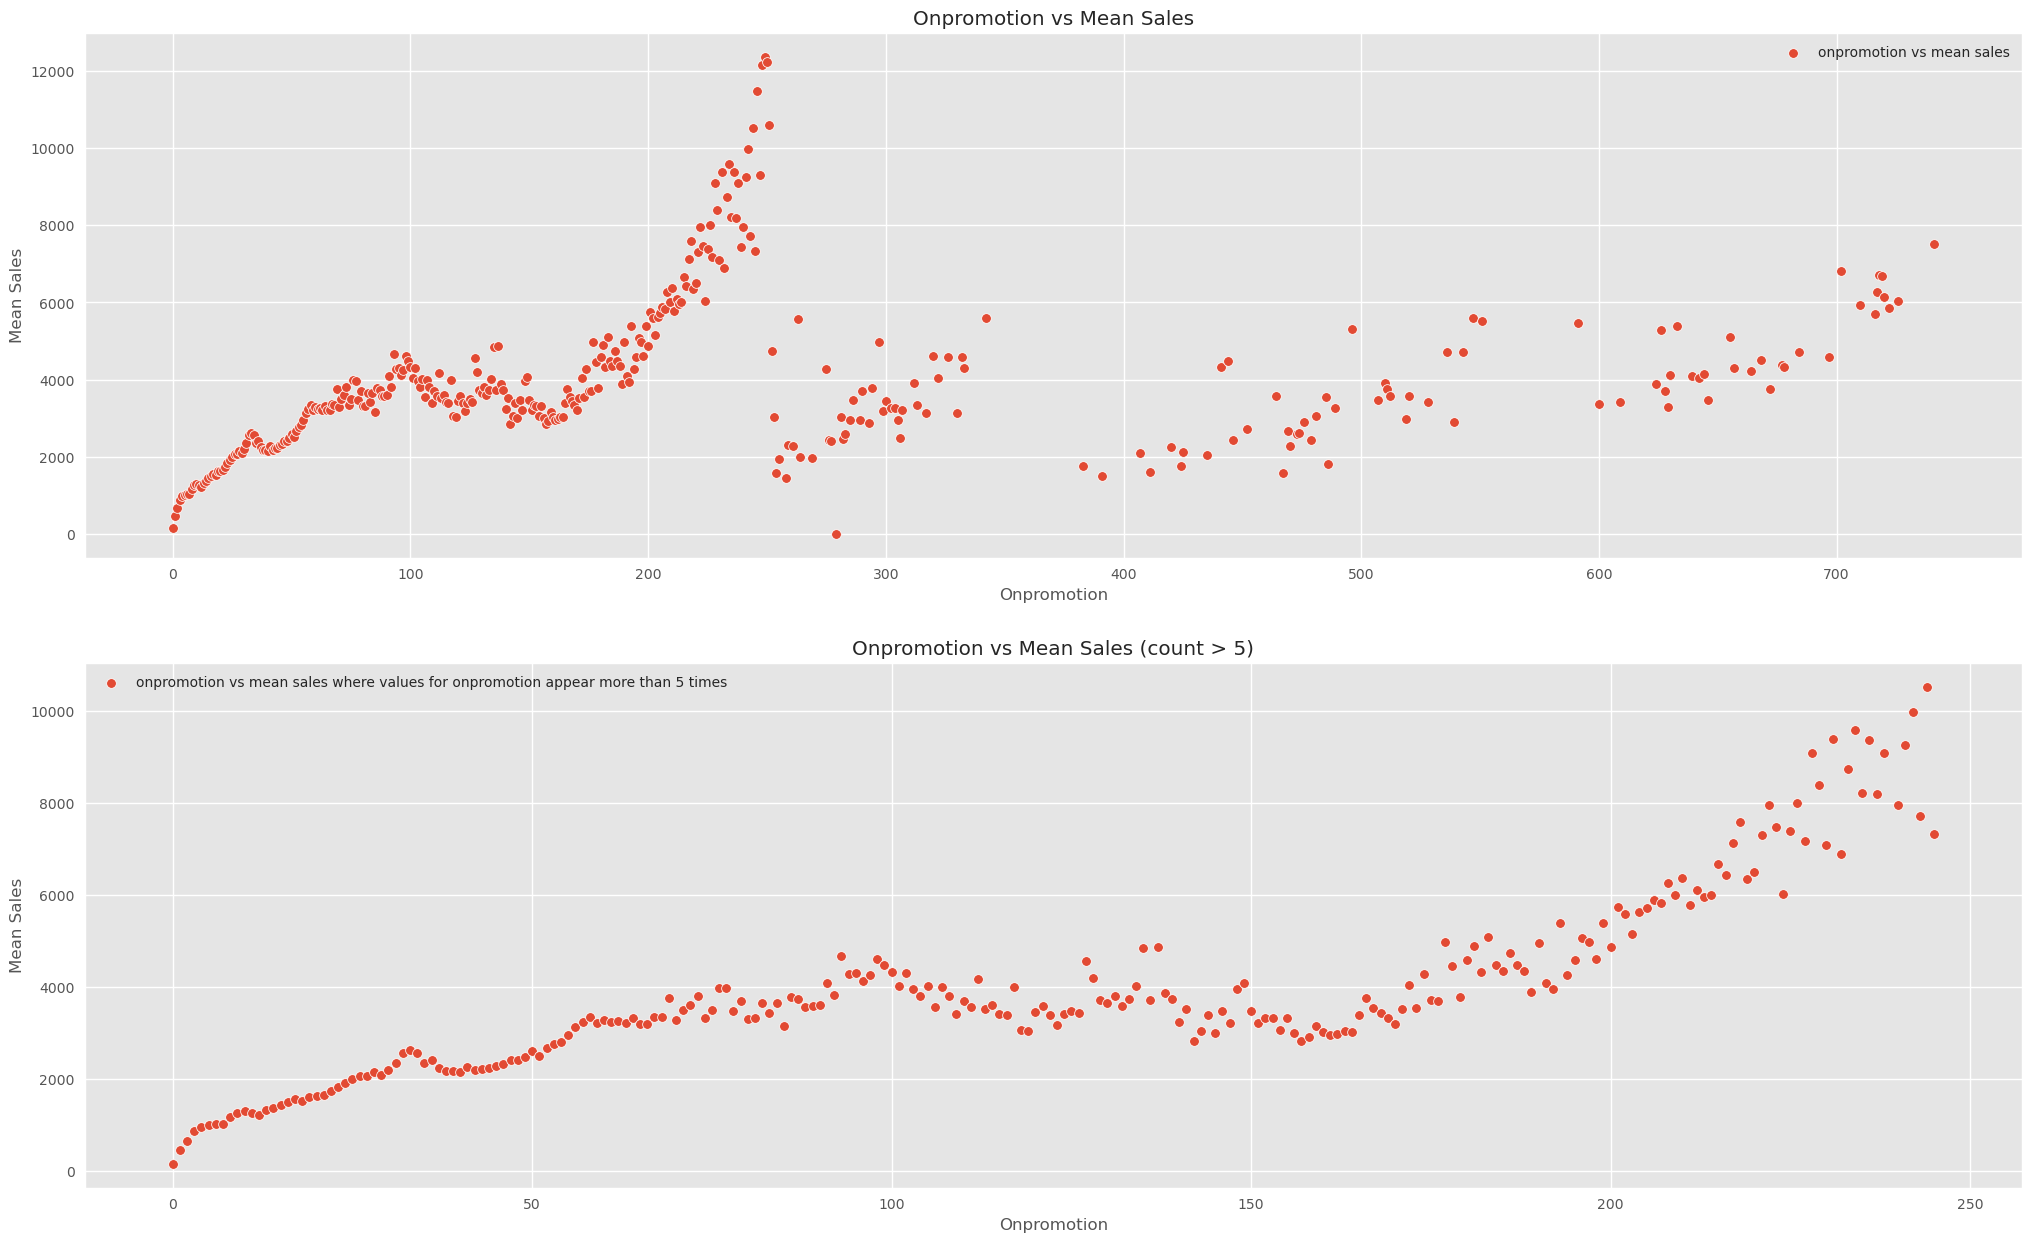

In [113]:
# Calculate correlation between sales and onpromotion
print("Spearman Correlation between Sales and Onpromotion: {:,.4f}".format(train.corr("spearman").sales.loc["onpromotion"]))

# Visualize onpromotion vs mean sales
plt.figure(figsize=(25, 15)) 
aggregated_on_promotion = train.groupby(['onpromotion'])['sales'].agg(['median','mean',  'count'])
plt.subplot(211)
sns.scatterplot(data=aggregated_on_promotion, x='onpromotion', y='mean', label='onpromotion vs mean sales')
plt.title('Onpromotion vs Mean Sales')
plt.xlabel('Onpromotion')
plt.ylabel('Mean Sales')

# Visualize onpromotion vs mean sales where values for onpromotion appear more than 5 times
plt.subplot(212)
sns.scatterplot(data=aggregated_on_promotion.query('count > 5'), x='onpromotion', y='mean', label='onpromotion vs mean sales where values for onpromotion appear more than 5 times')
plt.title('Onpromotion vs Mean Sales (count > 5)')
plt.xlabel('Onpromotion')
plt.ylabel('Mean Sales')

plt.show()

In [114]:
train.groupby(['onpromotion'])['sales'].agg(['mean', 'median', 'count'])

,mean,median,count
onpromotion,,,
0.00,158.25,3.00,2389559
1.00,467.56,145.35,174551
2.00,662.93,245.31,79386
3.00,871.41,325.39,45862
4.00,969.92,346.00,31659
...,...,...,...
719.00,6681.00,6681.00,1
720.00,6154.00,6154.00,1
722.00,5846.00,5846.00,1


In general there is a trend that the more items ar on promotion the more are the mean sales. However the relation between the variables is not totally linear. We will create an additional variable for binary encodding if any items were onpromotion at all, since most of the rows have a value of zero and the amount of sales is very low on them, so it should be good for our prediction.

In [115]:
# Create a new column called 'promotions_present' to indicate if a promotion is present for a particular item on a particular day
merged['promotions_present'] = np.where(merged['onpromotion'] > 0, 1, 0)

# Splitting dataset to train and validation sets

We will make validation for a short period since the task is to predict the figures for only 15 days.

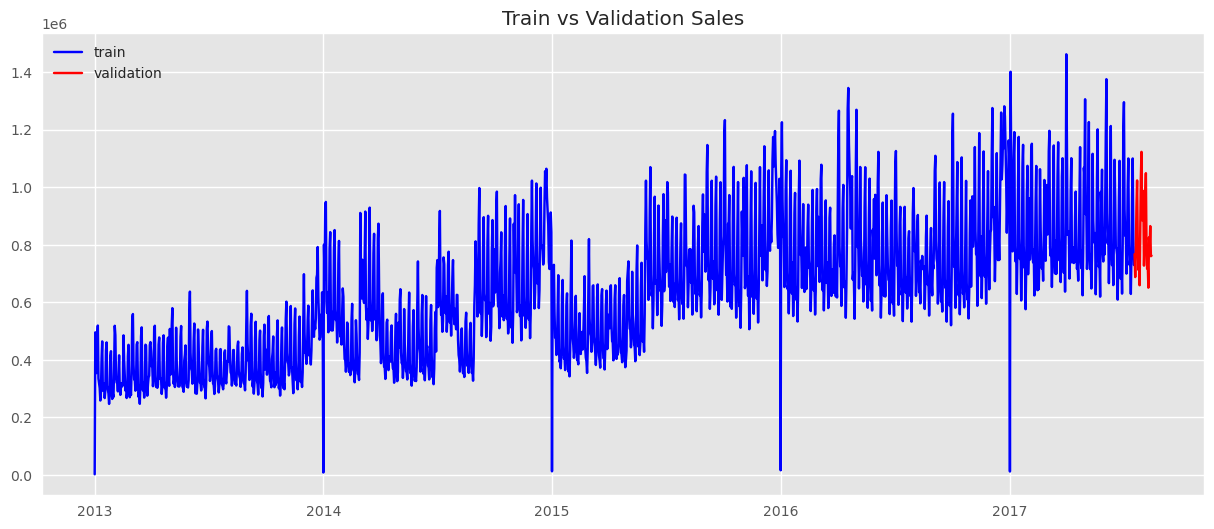

In [116]:

train_end_date = merged.loc[~merged['sales'].isna(), 'date'].max()
test_size = len(merged.loc[merged['sales'].isna()])

train = merged.loc[(merged['date'] <= train_end_date - dt.timedelta(days=28)) & (~merged['sales'].isna())].copy()
validation = merged.loc[(merged['date'] <= train_end_date) & (merged['date'] > train_end_date - dt.timedelta(days=28)) & (~merged['sales'].isna())].copy()
test = merged.loc[merged['sales'].isna()].copy()

train_sales = pd.DataFrame(train.groupby(['date'])['sales'].sum())
validation_sales = pd.DataFrame(validation.groupby(['date'])['sales'].sum())

# Merge train and validation sales dataframes
merged_sales = train_sales.merge(validation_sales, how='outer', left_index=True, right_index=True, suffixes=('_train', '_validation'))

# Plot the merged sales dataframe with different colors for train and validation
plt.figure(figsize=(15,6))
plt.plot(merged_sales.sales_train, color='blue', label='train')
plt.plot(merged_sales.sales_validation, color='red', label='validation')
plt.legend()
plt.title('Train vs Validation Sales')
plt.show()


In [117]:
new_train = train.loc[(train['date'] >= dt.datetime(2016, 5, 1)) & (train['date'] < dt.datetime(2016, 8, 1))]
new_train.shape

(163944, 31)

# Model Selection using PyCaret

In [118]:
# initialize setup
s = setup(data = new_train, date_features = ['date'],
        categorical_features = ['store_nbr', 'family', 'cluster', 'city', 'state', 'store_type', 'regional_type',
       'regional_locale', 'regional_transferred', 'type', 'local_locale',
       'transferred', 'national_type', 'national_locale', 'locale_name',
       'national_transferred',  'day', 'month', 'quarter',
       'year', 'promotions_present'], normalize_method='minmax',                
              remove_multicollinearity = True, multicollinearity_threshold = 0.9,
                feature_selection = True ,n_features_to_select = 0.8,
                feature_selection_method='univariate', # classic   univariate
                feature_selection_estimator = 'rf', 
          test_data = validation, 
          ordinal_features = {'day_of_week': [0, 1, 2, 3, 4, 5, 6], 'day': np.arange(0,32,1).tolist()},
          target = 'sales', 
          #fold_strategy = 'timeseries' - shows worse on validation on this dataset 
          numeric_features = [ 'dcoilwtico', 'trend_slope', 
       'previous_month_sales', 'previous_quarter_sales', 'previous_year_sales',
        'transactions', 'onpromotion'], 
              ignore_features = [  
       ],     
          fold = 5, fold_strategy = 'timeseries',
          transform_target = True)
models = compare_models(sort='RMSLE', include = ['gbr', 'lightgbm', 'catboost'], turbo = True,verbose = True)

,Description,Value
0,Session id,1557
1,Target,sales
2,Target type,Regression
3,Original data shape,"(213840, 31)"
4,Transformed data shape,"(213840, 25)"
5,Transformed train set shape,"(163944, 25)"
6,Transformed test set shape,"(49896, 25)"
7,Ordinal features,10
8,Numeric features,7
9,Date features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,67.0657,81068.3102,282.3441,0.9399,0.3886,0.4383,11.3380
lightgbm,Light Gradient Boosting Machine,64.7627,75861.8083,272.4783,0.9437,0.4229,0.4554,3.4480
catboost,CatBoost Regressor,67.5594,81586.1015,283.1973,0.9402,0.4624,0.4891,15.4580


Processing:   0%|          | 0/17 [00:00<?, ?it/s]


We will go on with Gradient Boosting Regressor - best score on the competion metric.


In [119]:
# train the model
gbr = create_model('gbr')

# extract the parameters of the tuned model
params = gbr.get_params()

print(params)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,70.9366,53266.0078,230.7943,0.9605,0.4164,0.5115
1,61.4686,61958.7964,248.9152,0.9585,0.3750,0.4405
2,63.1702,98523.1634,313.8840,0.9205,0.3861,0.4101
3,57.0288,85516.2642,292.4316,0.9416,0.3730,0.3778
4,82.7245,106077.3193,325.6951,0.9187,0.3926,0.4518
Mean,67.0657,81068.3102,282.3441,0.9399,0.3886,0.4383
Std,9.0269,20435.4998,36.7443,0.0179,0.0156,0.0447


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1557, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


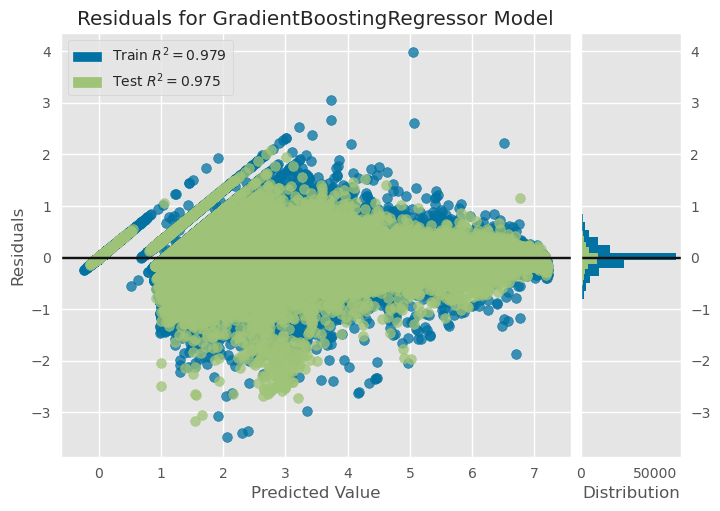

In [120]:
plot_model(estimator = gbr)

## Fitting and applying separate  models to each store_nbr

In [121]:
merged_train = pd.concat([new_train, validation], axis=0, ignore_index=True) # merging validation set to df, to improve score on the test set

In [122]:
merged_train.head()
merged_train = merged_train.drop('date', axis = 1)

In [123]:
families = merged_train.groupby('family')['sales'].sum().sort_values(ascending=True)
families

family
BOOKS                              22.00
BABY CARE                        1542.00
HOME APPLIANCES                  2176.00
HARDWARE                         7931.00
BEAUTY                          32977.00
LINGERIE                        37024.00
MAGAZINES                       40642.00
PET SUPPLIES                    43560.00
AUTOMOTIVE                      44390.00
LAWN AND GARDEN                 49753.00
PLAYERS AND ELECTRONICS         62267.00
SCHOOL AND OFFICE SUPPLIES      72228.00
LADIESWEAR                      74506.00
CELEBRATION                     88198.00
GROCERY II                     145876.00
SEAFOOD                        146458.28
HOME AND KITCHEN II            172110.00
HOME AND KITCHEN I             197041.00
LIQUOR,WINE,BEER               604418.00
PREPARED FOODS                 650402.56
FROZEN FOODS                   844586.44
EGGS                          1200489.00
HOME CARE                     1835209.00
DELI                          1880565.88
PERSONAL 

In [124]:
merged_train['family'] = merged_train['family'].replace({'LIQUOR,WINE,BEER': 'LIQUOR_WINE_BEER'})

In [125]:
# Define the target variable and predictors
target_col = 'sales'
predictor_cols = [col for col in merged_train.columns if col != target_col]

# Select numerical and categorical columns
num_cols = merged_train.select_dtypes(include=['float64', 'int64']).columns[merged_train.select_dtypes(include=['float64', 'int64']).columns != 'sales']
cat_cols = merged_train.select_dtypes(include=['object', 'category', 'string']).columns[merged_train.select_dtypes(include=['object', 'category', 'string']).columns != 'family']
merged_train[cat_cols]=merged_train[cat_cols].astype('string')



In [126]:
grouped_data = merged_train.groupby('family')
list_of_dfs = list(grouped_data)
print(list_of_dfs[22][0])  # print the family name
print(list_of_dfs[22][1].head())  # print the first five rows of the corresponding dataframe

LIQUOR_WINE_BEER
     store_nbr            family  sales  onpromotion  transactions  \
22           1  LIQUOR_WINE_BEER   0.00         0.00          0.00   
55          10  LIQUOR_WINE_BEER   0.00         0.00          0.00   
88          11  LIQUOR_WINE_BEER   0.00         0.00          0.00   
121         12  LIQUOR_WINE_BEER   0.00         0.00          0.00   
154         13  LIQUOR_WINE_BEER   0.00         0.00          0.00   

     dcoilwtico       city      state store_type  cluster  ...  day_of_week  \
22        44.75      Quito  Pichincha          D       13  ...            6   
55        44.75      Quito  Pichincha          C       15  ...            6   
88        44.75    Cayambe  Pichincha          B        6  ...            6   
121       44.75  Latacunga   Cotopaxi          C       15  ...            6   
154       44.75  Latacunga   Cotopaxi          C       15  ...            6   

     day  month quarter  year trend_slope previous_month_sales  \
22     1      5      

### Multiple XGBoosts

In [127]:
params = [
  (0.01, 0.0, 5),
  (0.1, 0.0, 3),
  (0.1, 0.1, 5),
  (0.01, 0.1, 5),
  (0.1, 0.0, 8),
  (0.01, 0.1, 8),
]

In [128]:
def tune_xgb_model(X_train, y_train, X_val, y_val, params, num_rounds=100):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    model = None
    best_score = float('+inf')

    for learning_rate, gamma, max_depth in params:
        xgb_params = {
            'learning_rate': learning_rate,
            'gamma': gamma,
            'max_depth': int(max_depth),
            'subsample': 1,
           # 'colsample_bytree': 0.8,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmsle',
            'tree_method': 'hist',
        }

        xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=num_rounds,
                              evals=watchlist, early_stopping_rounds=20, verbose_eval=False)
        
        eval_result = xgb_model.eval(dval, 'rmsle') # Pass the 'rmsle' metric as a string
        eval_score = float(eval_result.split(':')[1].strip()) # Extract the score from the result

        if eval_score < best_score: # Use 'less is better' since RMSLE should be minimized
            model = xgb_model
            best_score = eval_score

    return model

alpha=0.9,
                          ccp_alpha=0.0,
                          criterion='friedman_mse',
                          init=None,
                          learning_rate=0.1,
                          loss='squared_error',
                          max_depth=3,
                          max_features=20,
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0,
                          min_samples_leaf=1,
                          min_samples_split=2,
                          min_weight_fraction_leaf=0.0,
                          n_estimators=100,
                          n_iter_no_change=None,
                          random_state=42,
                          subsample=1.0,
                          tol=0.0001,
                          validation_fraction=0.1,
                          verbose=2,
                          warm_start=False

In [129]:
preprocessing_transformer = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), num_cols),
    ('imputer', SimpleImputer(), num_cols),
    ('one_hot_encoder', OneHotEncoder(handle_unknown = 'ignore'), cat_cols)
])

feature_selection_transformer = Pipeline(steps=[
    ('feature_selection', SelectKBest(mutual_info_regression, k=20))
])

full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_transformer),
    ('feature_selection', feature_selection_transformer)
])

In [130]:
outlier_removal_transformer = EllipticEnvelope(contamination=0.01)

In [131]:
def fit_xgb_model(X, y, params):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=43)
    model = tune_xgb_model(X_train, y_train, X_val, y_val, params ) #
    return model

xgb_models = {}

for family, group in list_of_dfs:
    # Separate the target variable and predictors for the current group
    y = group[target_col]
    X = group[predictor_cols]

    cv = TimeSeriesSplit(n_splits=3)

    xgb_scores = []
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_processed = full_pipeline.fit_transform(X_train, y_train)
        X_val_processed = full_pipeline.transform(X_val)

        inliers = outlier_removal_transformer.fit(X_train_processed).predict(X_train_processed) == 1
        X_train_inliers = X_train_processed[inliers]
        y_train_inliers = y_train[inliers]

        model = fit_xgb_model(X_train_inliers, y_train_inliers, params) 

        score = model.eval(xgb.DMatrix(X_val_processed, label=y_val), 'rmsle')
        eval_scores = float(score.split(':')[1].strip())
        xgb_scores.append(eval_scores)
    print(f"Family: {family}, Mean RMSLE: {np.mean(xgb_scores)}")
    xgb_models[family] = model

Family: AUTOMOTIVE, Mean RMSLE: 0.5123959283015935
Family: BABY CARE, Mean RMSLE: 0.13728505177984576
Family: BEAUTY, Mean RMSLE: 0.4244317180549249
Family: BEVERAGES, Mean RMSLE: 0.3807060669527725
Family: BOOKS, Mean RMSLE: 0.02724512861688022
Family: BREAD/BAKERY, Mean RMSLE: 0.4084208089834309
Family: CELEBRATION, Mean RMSLE: 0.5811147018660349
Family: CLEANING, Mean RMSLE: nan
Family: DAIRY, Mean RMSLE: 0.21144978257077165
Family: DELI, Mean RMSLE: 0.19540825354138702
Family: EGGS, Mean RMSLE: 0.5059400585795837
Family: FROZEN FOODS, Mean RMSLE: 0.3607025376917525
Family: GROCERY I, Mean RMSLE: 0.3673472057500908
Family: GROCERY II, Mean RMSLE: 0.7264470814364422
Family: HARDWARE, Mean RMSLE: 0.3220126414452829
Family: HOME AND KITCHEN I, Mean RMSLE: 0.7373818411292926
Family: HOME AND KITCHEN II, Mean RMSLE: 0.5283112368550956
Family: HOME APPLIANCES, Mean RMSLE: 0.1221221700526521
Family: HOME CARE, Mean RMSLE: 0.2774182465249794
Family: LADIESWEAR, Mean RMSLE: 0.470049565409708

### Prediction on test set

In [133]:
test['family'] = test['family'].replace({'LIQUOR,WINE,BEER': 'LIQUOR_WINE_BEER'})

In [134]:
# Define a dictionary to store the test predictions for each category
test_predictions = {}

# Loop over the XGBoost models for each category and make predictions for the test set
for family, model in xgb_models.items():

    # Separate the target variable and predictors for the current category in the test set
    category_test = test[test['family'] == family]
    y_test = category_test[target_col]
    X_test = category_test[predictor_cols]

    # Apply the preprocessing pipeline fitted on the train set to the test set
    X_test_processed = full_pipeline.transform(X_test)

    # Generate predictions from the XGBoost model for the test set
    y_pred = model.predict(xgb.DMatrix(X_test_processed))

    # Store the XGBoost model predictions for the current category
    test_predictions[family] = y_pred

# Combine the test predictions from all categories into a single DataFrame
merged_test_pred = pd.concat([pd.Series(test_predictions[family], index=test[test['family'] == family].index, name=target_col) for family in xgb_models.keys()])

# Ensure the merged_test_pred DataFrame has the same index as the original test set
merged_test_pred = merged_test_pred.reindex(test.index)

# Submission

In [ ]:
# reset index to a column
submission = merged_test_pred.reset_index()
# rename columns
submission = submission.rename(columns={'index': 'id', 'prediction_label':'sales'})
# if negative convert to a zero prediction:
submission['sales'] = [0 if x < 0 else x for x in submission['sales']]
submission[['id', 'sales']].to_csv('output1.csv',index=False)

# Suggestions for improvement

One might consider fitting multiple models, i.e. a model for each combination of store and product family. Drawback - it will be really time consuming, given  54 unique values for the store_nbr and 33 for the family.

Implementing grouped KFold validation might be tested as well.

One can also play around with the threshold for the training data that is used for fitting to find balance for preventing feeding the model with already outdated information and providing sufficient data for identifying patterns.

Finally we can try engineering additional features or extract them from other data sources.